## Baseline Model Notebook

Here, we check for stationarity in the time series df, remove trends, TTS and create a baseline model.

In [57]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import seaborn as sns
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


## 1) load in original `.csv` file

In [58]:
df = pd.read_csv('data/extracted/crime-data-from-2010-to-present.csv')
df.head(3)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,102005556,2010-01-25T00:00:00,2010-01-22T00:00:00,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"{'latitude': '34.0454', 'needs_recoding': Fals..."
1,101822289,2010-11-11T00:00:00,2010-11-10T00:00:00,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"{'latitude': '33.9572', 'needs_recoding': Fals..."
2,101105609,2010-01-28T00:00:00,2010-01-27T00:00:00,2230,11,Northeast,1125,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,YORK,AVENUE 51,"{'latitude': '34.1211', 'needs_recoding': Fals..."


In [59]:
# cleaning time columns
df["Date Occurred"] = df["Date Occurred"].str.replace('T00:00:00', '')
df["Date Reported"] = df["Date Occurred"].str.replace('T00:00:00', '')
# # converting them to time series
df['Date Occurred'] = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')
df['Date Reported'] = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')

In [60]:
# creating new df
time_df = df.groupby('Date Occurred').size().reset_index()
time_df = time_df.set_index('Date Occurred')
time_df = time_df.rename({0: 'crime_count'}, axis='columns')

In [61]:
time_df.head()

,crime_count
Date Occurred,
2010-01-01,2222
2010-01-02,533
2010-01-03,539
2010-01-04,558
2010-01-05,547


## Checking for Stationarity

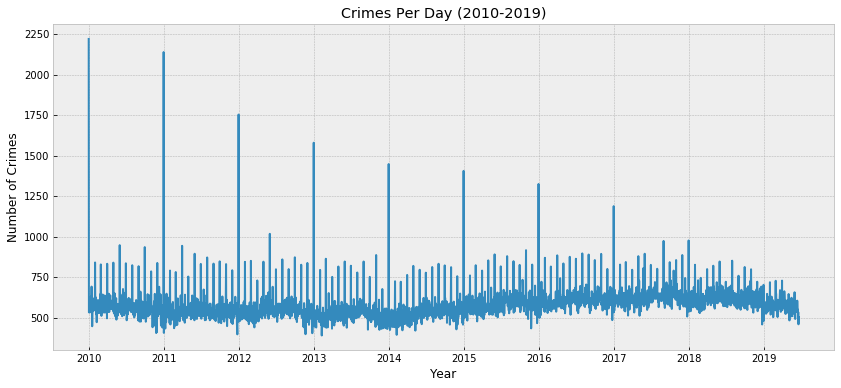

In [62]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_df['crime_count'])
plt.title('Crimes Per Day (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')

plt.savefig('visualizations/orig_time_data.png', bbox_inches = "tight", pad_inches=.5)

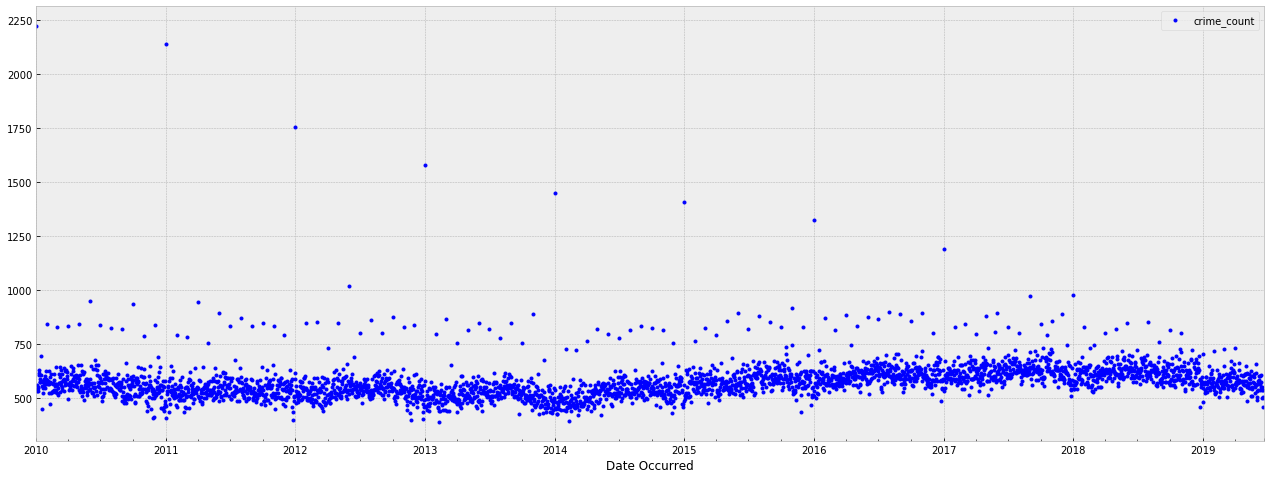

In [63]:
time_df.plot(figsize = (22,8), style = 'b.')
plt.show()

## Dickey Fuller Test

In [64]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(time_df['crime_count'])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                   -2.190871
p-value                           0.209576
# of Lags Used                   30.000000
Number of Observations Used    3429.000000
dtype: float64


we fail to reject the null because the p-value is above 0.05. this means that the original data is not stationary.

## Fixing Stationarity by Subtracting Rolling Mean

In [65]:
roll_mean = time_df.rolling(window=3, min_periods=1).mean()
roll_std = time_df.rolling(window=3, min_periods=1).std()

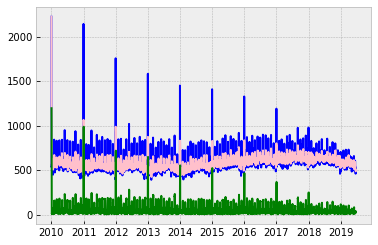

In [66]:
plt.plot(time_df['crime_count'], color = 'blue')
plt.plot(roll_mean, color = 'pink')
plt.plot(roll_std, color = 'green')

In [67]:
roll_mean

,crime_count
Date Occurred,
2010-01-01,2222.000000
2010-01-02,1377.500000
2010-01-03,1098.000000
2010-01-04,543.333333
2010-01-05,548.000000
...,...
2019-06-18,528.333333
2019-06-19,527.000000
2019-06-20,496.666667


In [68]:
standardized_data = time_df - roll_mean
standardized_data.head()

,crime_count
Date Occurred,
2010-01-01,0.000000
2010-01-02,-844.500000
2010-01-03,-559.000000
2010-01-04,14.666667
2010-01-05,-1.000000


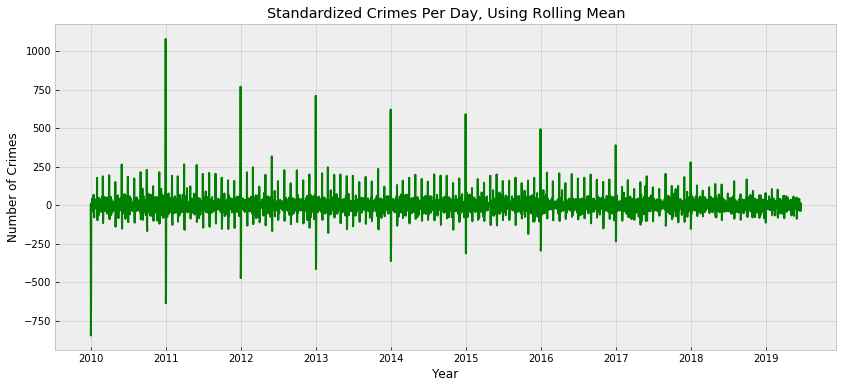

In [69]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(standardized_data['crime_count'], color='green')
plt.title('Standardized Crimes Per Day, Using Rolling Mean')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')

plt.savefig('visualizations/minus_rolling_mean.png', bbox_inches = "tight", pad_inches=.5)

In [70]:
standardized_data.isna().sum()

crime_count    0
dtype: int64

In [71]:
# # fill null them with the median
# standardized_data['crime_count'].fillna((standardized_data['crime_count'].median()), inplace=True)

In [72]:
standardized_data.head()

,crime_count
Date Occurred,
2010-01-01,0.000000
2010-01-02,-844.500000
2010-01-03,-559.000000
2010-01-04,14.666667
2010-01-05,-1.000000


In [73]:
# dickey fuller test on new data
test = adfuller(standardized_data['crime_count'])
output = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(output)

# why is the p-value 0?

Test Statistic                  -23.629913
p-value                           0.000000
# of Lags Used                   30.000000
Number of Observations Used    3429.000000
dtype: float64


## Graphing ACF & PACF
This code will need to be rerun after straionarity is fixed

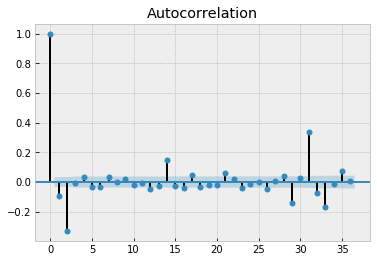

In [74]:
#plot autocorrelation for each lag (alpha is confidence interval)
plot_acf(standardized_data['crime_count'], alpha=.05)
plt.show()

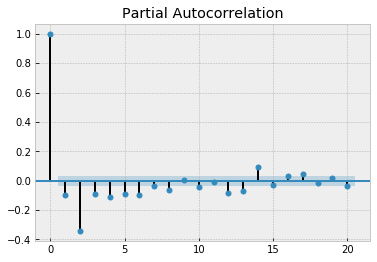

In [75]:
plot_pacf(standardized_data['crime_count'], alpha=.05, lags=20)
plt.show()

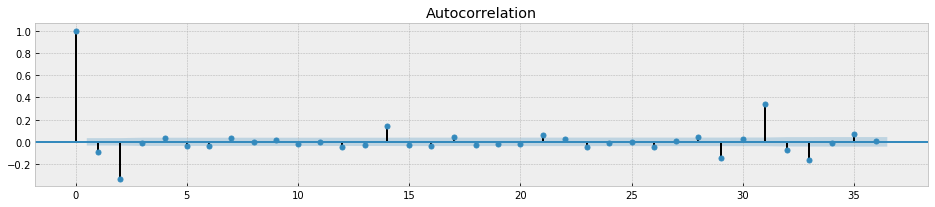

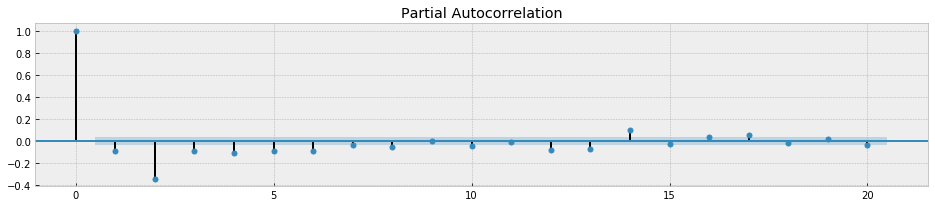

In [76]:
# graphing ACF & PACF together on 1 figure

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(standardized_data['crime_count'], alpha=.05, ax=ax)
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(standardized_data['crime_count'], alpha=.05, lags=20, ax=ax)
plt.show()

## Train-Test Split

In [77]:
# from sklearn.model_selection import TimeSeriesSplit
# tss = TimeSeriesSplit(n_splits = 3)

In [78]:
# X = time_df.drop(labels=['crime_count'], axis=1)
# y = time_df['crime_count']

In [79]:
# for train_index, test_index in tss.split(X):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#### Trying to split df with .loc

In [80]:
train_set = standardized_data.loc['2010-01-01':'2017-12-31']
test_set = standardized_data.loc['2018-01-01':'2019-06-22']

In [81]:
# X_train, X_test = 
# y_train, y_test = 

## Baseline Model: Autoregression (AR) Model

In [82]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn import metrics

In [83]:
baseline_model = AutoReg(train_set, 3)
output = baseline_model.fit()
print(output.summary())

                            AutoReg Model Results                             
Dep. Variable:            crime_count   No. Observations:                 2922
Model:                     AutoReg(3)   Log Likelihood              -16125.483
Method:               Conditional MLE   S.D. of innovations             60.666
Date:                Thu, 03 Dec 2020   AIC                              8.214
Time:                        19:12:33   BIC                              8.224
Sample:                    01-04-2010   HQIC                             8.218
                         - 12-31-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.2426      1.123     -0.216      0.829      -2.443       1.958
crime_count.L1    -0.2042      0.018    -11.338      0.000      -0.240      -0.169
crime_count.L2    -0.3630      0.017

In [84]:
# predictions = baseline_model.predict(test_set)


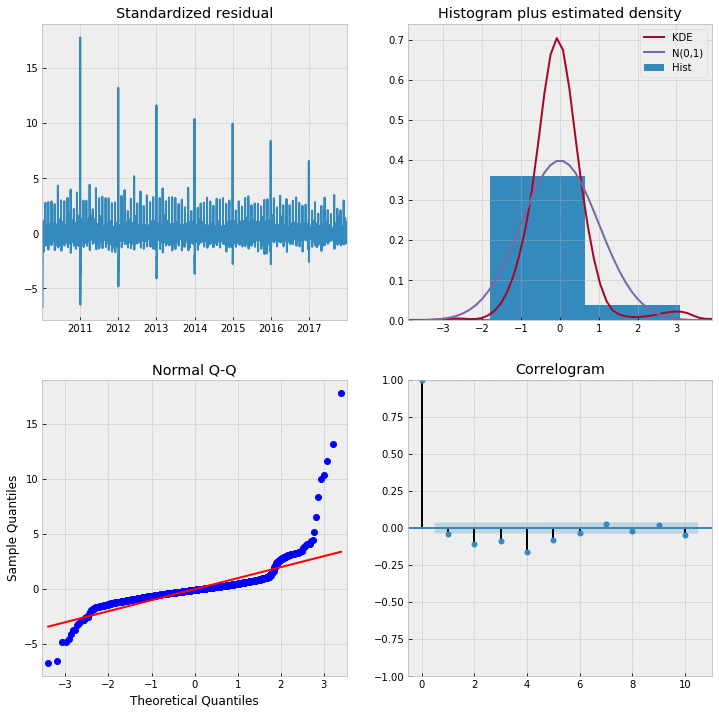

In [85]:
# not sure what this is?
output.plot_diagnostics(figsize=(12, 12))
plt.show()

No handles with labels found to put in legend.


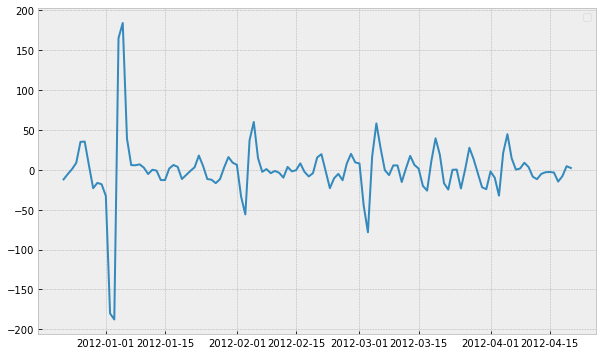

In [86]:
# not sure what this is either?

fig = output.plot_predict(720, 840, figsize=(10,6))

### ARIMA Model (?)

In [87]:
# model = ARIMA(train_set[:-1], order=(2,1,1))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())